In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F 
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml import Pipeline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Data information

Obtained from: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/data

There are 6 different variations of the dataset. This notebook uses the 'Base' version, as it was sampled to best represent the original dataset. 

### Features and explaantions:
1) fraud_bool: Fraud label (1 if fraud, 0 if legit)
2) income: Annual income of the applicant in quantiles. Ranges between [0, 1]
3) name_email_similarity: Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [0, 1].
4) prev_address_months_count: Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).
5) customer_age: Applicant’s age in bins per decade (e.g, 20-29 is represented as 20).
6) days_since_request: Number of days passed since application was done. Ranges between [0, 78] days.
7) intended_balcon_amount: Initial transferred amount for application. Ranges between [−1, 108].
8) zip_count_4w: Number of applications within same zip code in last 4 weeks. Ranges between [1, 5767].
9) velocity_6h: Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [−211, 24763]. 
10) velocity_24h: Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1329, 9527].
11) velocity_4w: Velocity of total applications made in last 4 weeks, i.e., average number of applications per hour in the last 4 weeks. Ranges between [2779, 7043].
12) bank_branch_count_8w: Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2521].
13) date_of_birth_distinct_emails_4w: Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 42].
14) credit_risk_score: Internal score of application risk. Ranges between [−176, 387].
15) email_is_free: Domain of application email (either free or paid).
16) phone_home_valid: Validity of provided home phone.
17) phone_mobile_valid: Validity of provided mobile phone.
18) bank_months_count: How old is previous account (if held) in months. Ranges between [−1, 31] months (-1 is a missing value).
19) has_other_cards: If applicant has other cards from the same banking company.
20) proposed_credit_limit: Applicant’s proposed credit limit. Ranges between [200, 2000].
21) foreign_request: If origin country of request is different from bank’s country.
22) session_length_in_minutes: Length of user session in banking website in minutes. Ranges between [−1, 107] minutes
23) keep_alive_session: User option on session logout.
24) device_distinct_emails_8w: Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [0, 3].
25) device_fraud_count: Number of fraudulent applications with used device. Ranges between [0, 1].
26) month: Month where the application was made. Ranges between [0, 7].
27) payment_type: Credit payment plan type. 5 possible (annonymized) values.
28) employment_status: Employment status of the applicant. 7 possible (annonymized) values.
29) housing_status: Current residential status for applicant. 7 possible (annonymized) values.
30) source: Online source of application. Either browser(INTERNET) or mobile app (APP).
31) device_os: Operative system of device that made request. Possible values are: Windows, Macintox, Linux, X11, or other.
32) current_address_months_count: Months in currently registered address of the applicant. Ranges between [−1, 406] months (-1 is a missing value).

# 1. Start spark session

In [2]:
spark = SparkSession.builder.appName("EDA").getOrCreate()

# 2. Read in data

In [10]:
local_path = "work/data/Base.csv"
hdfs_path = "hdfs://namenode:8020/data/Base.parquet"

try:
    df = spark.read.parquet(hdfs_path)
    print("Data already in HDFS")
except:
    print("Data not in HDFS → Storing data in HDFS")
    tmp_df = spark.read.csv(local_path, header=True, inferSchema=True)
    tmp_df.write.parquet(hdfs_path)
    df = spark.read.parquet(hdfs_path)

samples_count = df.count()
df = df.withColumn("sample_id", F.monotonically_increasing_id())
df.printSchema()

Data already in HDFS
root
 |-- fraud_bool: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: integer (nullable = true)
 |-- current_address_months_count: integer (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- zip_count_4w: integer (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: integer (nullable = true)
 |-- date_of_birth_distinct_emails_4w: integer (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- credit_risk_score: integer (nullable = true)
 |-- email_is_free: integer (nullable = true)
 |-- housing_status: string (nullable = true)
 |-- phone_home_valid: integer (nullable = t

# 3. Create test set

Before doing anything, I will take 10% of the data and set it aside as a locked test set (so that I don't do any exploration on it)

In [11]:
train_df, test_df = df.randomSplit([0.9, 0.1], seed=42)
df = train_df

# 4. Exploratory Data Analysis

## 4.1. Check for missing values 

In [7]:
# go over all samples based on columns and check if their value is either nan or null, if so store the sample id and the value 

samples_missing_val = None

for column in df.columns:
    # check for null and NaNs
    condition = F.col(column).isNull() | F.isnan(F.col(column))
    
    # samples where the condition is met and store them for future inspection
    column_errors = df.filter(condition).select(
        F.col("sample_id"),
        F.lit(column).alias("column_name"),
        F.col(column).alias("value") # actual value (null, NaN, or 0)
    )
    
    if samples_missing_val is None:
        samples_missing_val = column_errors
    else:
        samples_missing_val = samples_missing_val.union(column_errors)


print(f"There are {samples_missing_val.count()} samples with missing value.") 

There are 0 samples with missing value.


### Observation: No NaNs or null values are present


## 4.2. Check for class imbalance

In [12]:
class_counts_df = df.groupBy('fraud_bool').count()

class_percentage_df = class_counts_df.withColumn('percentage',(class_counts_df['count'] / samples_count) * 100)
class_percentage_df.show()

+----------+------+------------------+
|fraud_bool| count|        percentage|
+----------+------+------------------+
|         1|  9893|0.9893000000000001|
|         0|889916|           88.9916|
+----------+------+------------------+



### Observation: less than 1% of actual fraudulent accounts, indicating class imbalance.
This is bad! I will address it either by doing some data augmentation or checking if MLlib supports loss functions that handle the imbalance.


## 4.3. Check for outliers + patterns 

To do so, I will look into the data distributions and examine extreme values. But first, let's extract categorical and numerical features names so we can handle numerical and cat variables separate for the inspection of distributions. 

In [14]:
num_features = []
cat_features = []
issues = []

for feature, dtype in df.dtypes:
    if dtype == 'string':
        cat_features.append(feature)
    elif dtype == 'int' or dtype == 'double' or  dtype == 'long' or dtype == 'bigint':
        num_features.append(feature)
    else: 
        issues.append(feature)

print(f"There are {len(num_features) - 2} numerical features, {len(cat_features)} categorical, and {len(issues)} from neither.") 
# -2 because of id (sample_id) and the target variable (fraud_bool)

There are 26 numerical features, 5 categorical, and 0 from neither.


However, after doing some plots distributions and looking into the defitnion of some of the features considered as numerical, the following featuers should be categorical:
- keep_alive_session
- foreign_request
- has_other_cards
- phone_mobile_valid
- phone_home_valid
- email_is_free
- customer_age

In [15]:
cat_assigned_as_num = ['keep_alive_session', 'foreign_request', 'has_other_cards', 'phone_mobile_valid', 'phone_home_valid', 'email_is_free', 'customer_age']
num_features = [feature for feature in num_features if feature not in cat_assigned_as_num]
cat_features.extend(cat_assigned_as_num)

In [16]:
print(f"There are {len(num_features) - 2} numerical features, {len(cat_features)} categorical, and {len(issues)} from neither.") 


There are 19 numerical features, 12 categorical, and 0 from neither.


Methods used for plotting distributions

In [17]:
def cat_summary(df, col_name, plot=True):
    # Group by 'fraud_bool' and the categorical column to get counts
    fraud_value_counts_df = df.filter(df['fraud_bool'] == 1).groupBy(col_name).count()
    non_fraud_value_counts_df = df.filter(df['fraud_bool'] == 0).groupBy(col_name).count()
    if plot:
        # get values and occurances for fraud and non-fraud
        fraud_values = fraud_value_counts_df.select(col_name).rdd.flatMap(lambda x: x).collect()
        fraud_counts = fraud_value_counts_df.select('count').rdd.flatMap(lambda x: x).collect()
        non_fraud_values = non_fraud_value_counts_df.select(col_name).rdd.flatMap(lambda x: x).collect()
        non_fraud_counts = non_fraud_value_counts_df.select('count').rdd.flatMap(lambda x: x).collect()

        # adjust counts and values to the max category size
        max_categories = len(fraud_values) if len(fraud_values) > len(non_fraud_values) else len(non_fraud_values)
        index = range(max_categories)
        fraud_counts += [0] * (max_categories - len(fraud_counts))
        fraud_values += [''] * (max_categories - len(fraud_values))
        non_fraud_counts += [0] * (max_categories - len(non_fraud_counts))
        non_fraud_values += [''] * (max_categories - len(non_fraud_values))

        # plot
        plt.figure(figsize=(6, 4)) 
        bar_width = 0.35
        plt.bar(index, non_fraud_counts, bar_width, color='blue', label='Not Fraud', align='center')
        plt.bar([i + bar_width for i in index], fraud_counts, bar_width, color='red', label='Fraud', align='center')
        plt.xlabel(col_name)
        plt.ylabel("Count")
        plt.xticks([i + bar_width / 2 for i in index], fraud_values, rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        # Display counts for fraud and non-fraud
        fraud_value_counts_df.show()
        non_fraud_value_counts_df.show()
       

def num_summary(df, numerical_col, plot=True):
    if plot:
        # Extract data based on fraud or not
        fraud_data = df.filter(df['fraud_bool'] == 1).select(numerical_col).rdd.flatMap(lambda x: x).collect()
        non_fraud_data = df.filter(df['fraud_bool'] == 0).select(numerical_col).rdd.flatMap(lambda x: x).collect()
        
        plt.figure(figsize=(8, 4))
        # Continuous KDE plot
        plt.subplot(1, 2, 1)
        sns.kdeplot(non_fraud_data, color='blue', label='Not Fraud', fill=True)
        sns.kdeplot(fraud_data, color='red', label='Fraud', fill=True)
        plt.xlabel(numerical_col)
        plt.ylabel("Density")
        plt.legend()
        # boxplot
        plt.subplot(1, 2, 2)
        pandas_df = df.select('fraud_bool', numerical_col).toPandas()
        sns.boxplot(data=pandas_df, x='fraud_bool', y=numerical_col, hue = 'fraud_bool',palette=['blue', 'red'], boxprops=dict(alpha=.6), legend=False)
        #plt.boxplot([non_fraud_data, fraud_data], vert=False, tick_labels=['Not Fraud', 'Fraud'])
        plt.xlabel('Fraud or Not Fraud')
        plt.ylabel(numerical_col)
        plt.xticks([0, 1], ['Not Fraud', 'Fraud'])

        plt.tight_layout()
        plt.show()
    else:  
        df.describe([numerical_col]).show()


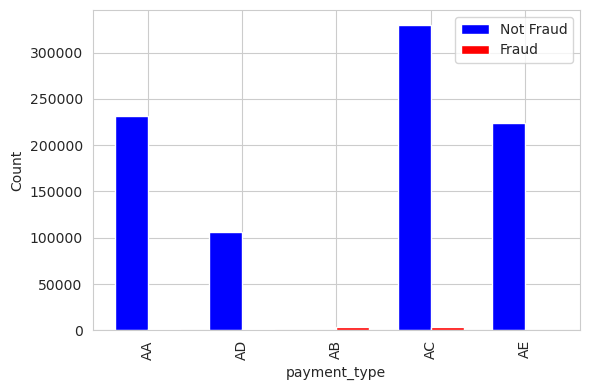

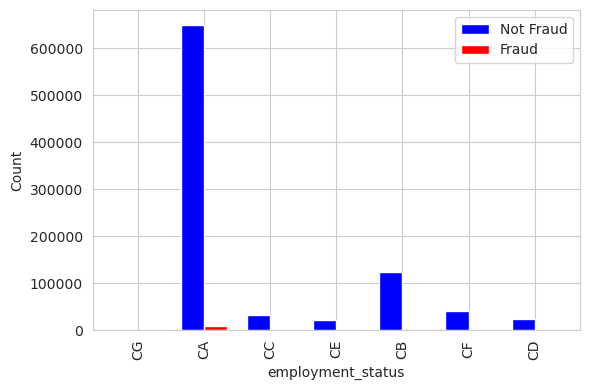

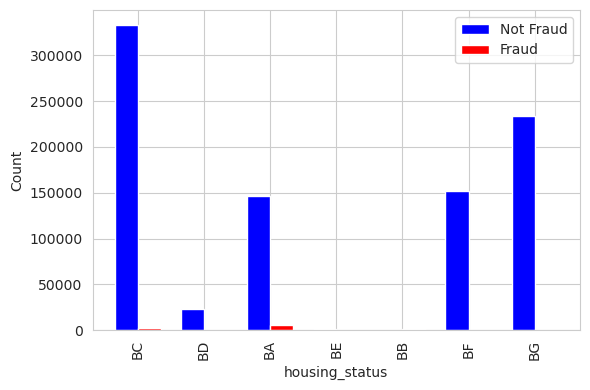

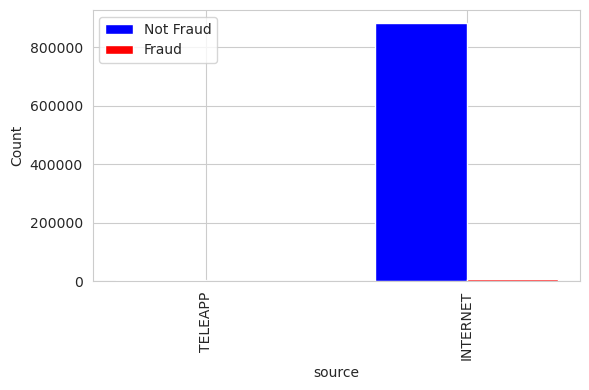

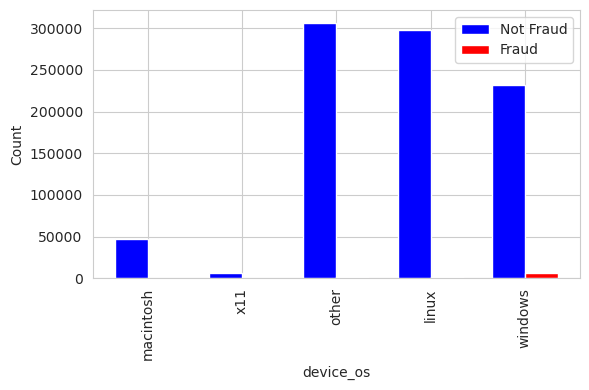

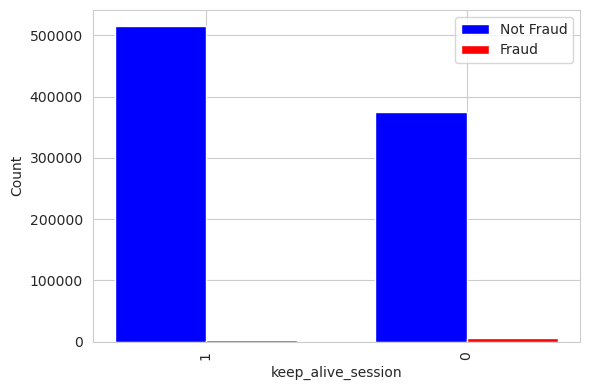

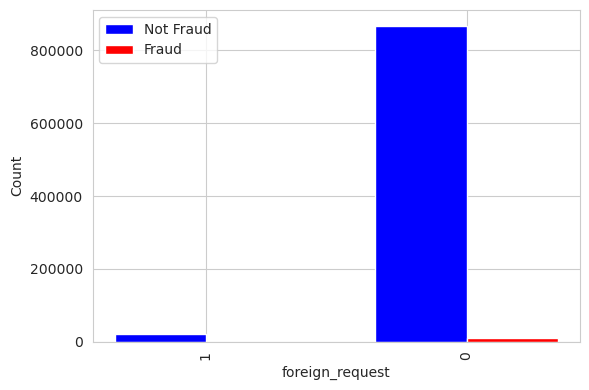

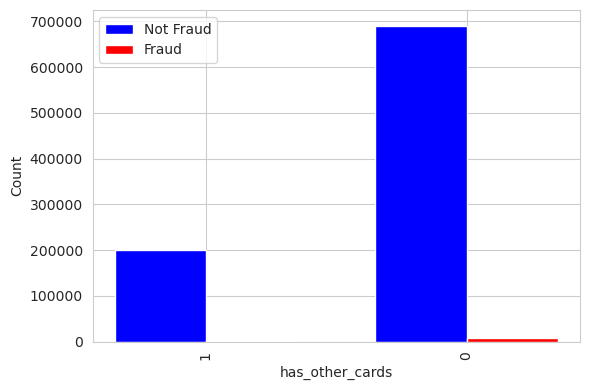

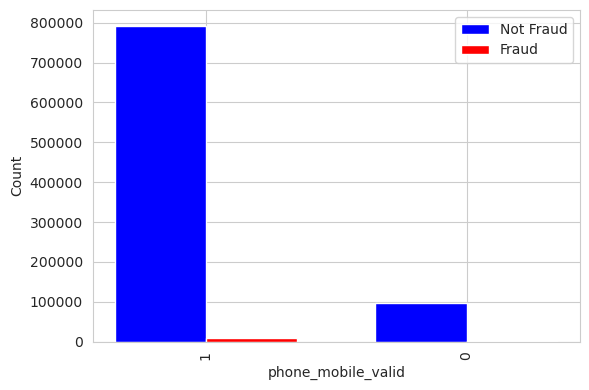

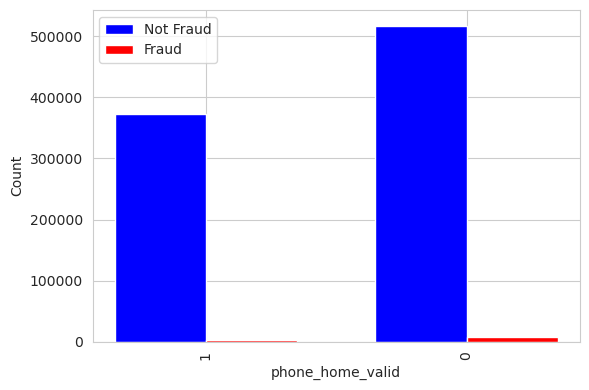

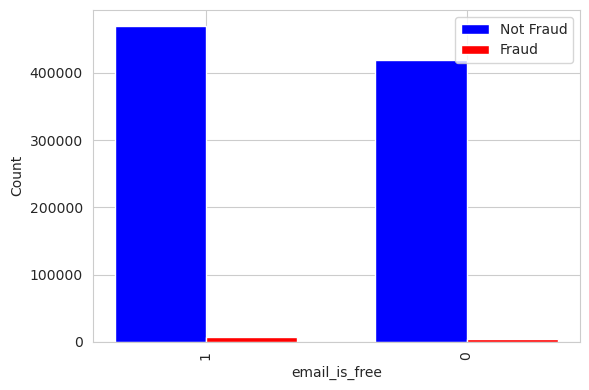

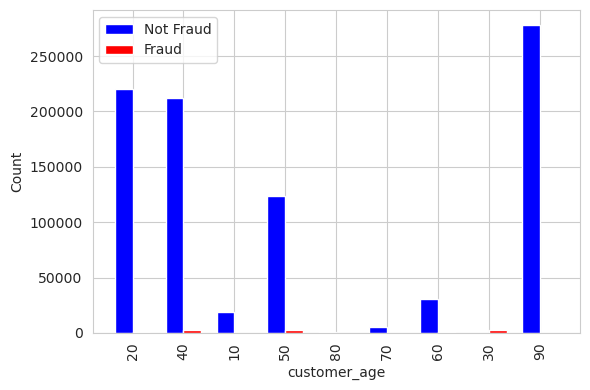

In [18]:
for feature in cat_features: 
    cat_summary(df, feature, True)

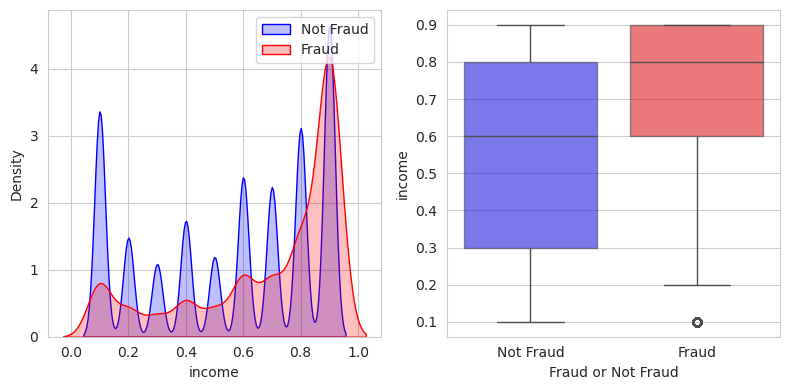

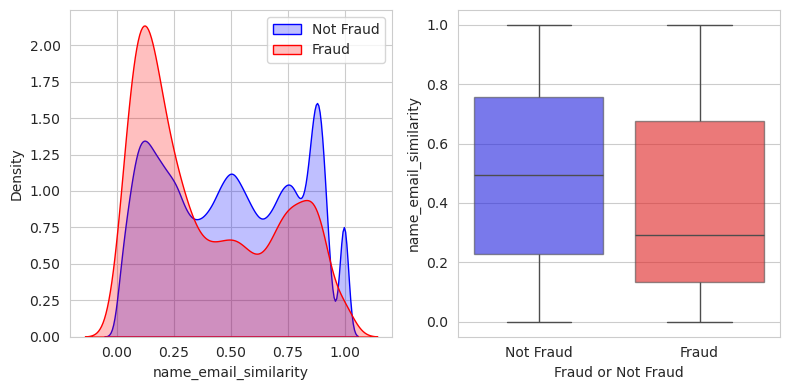

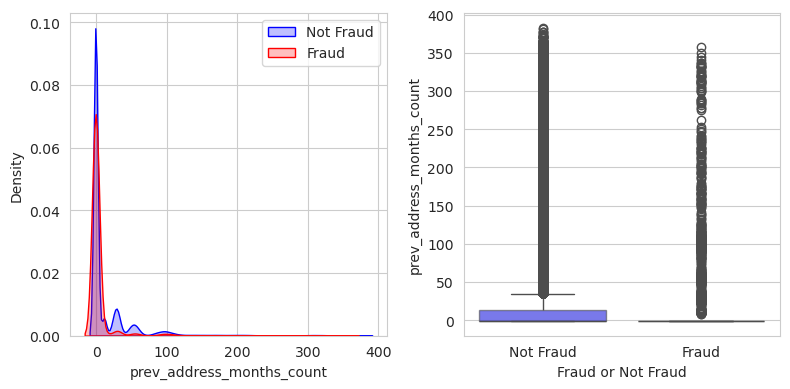

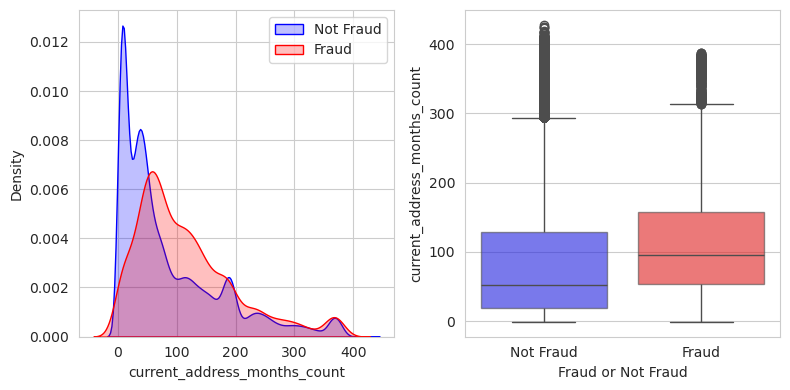

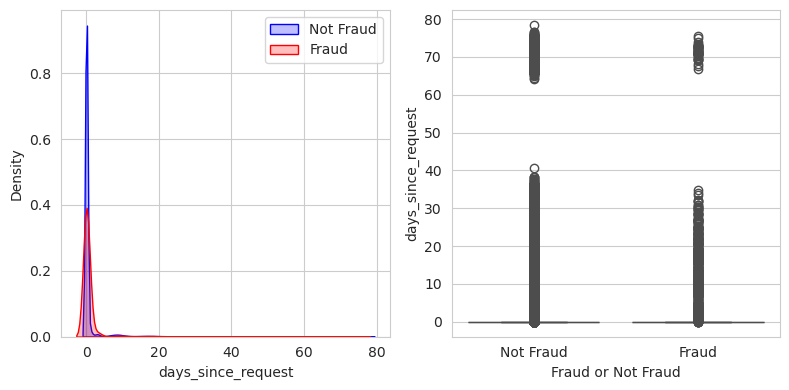

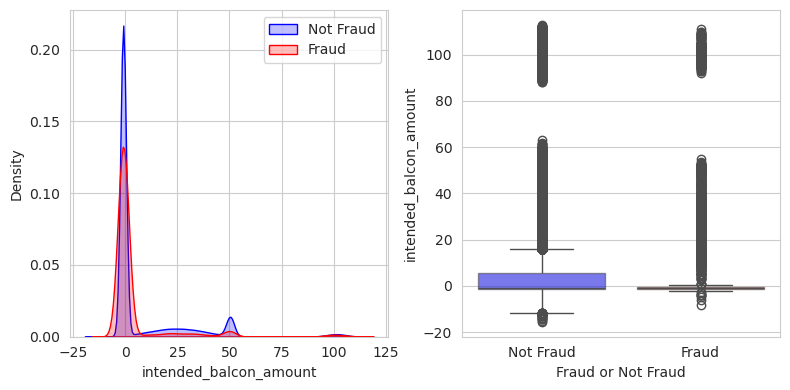

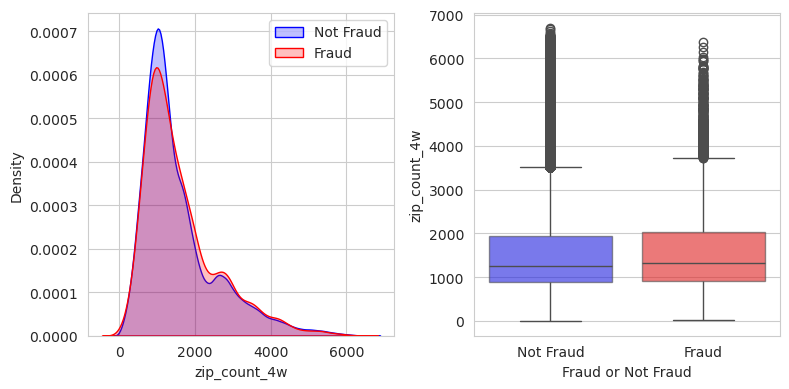

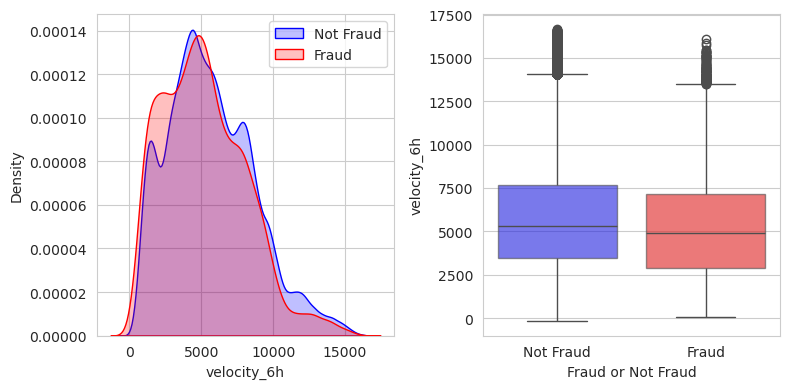

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

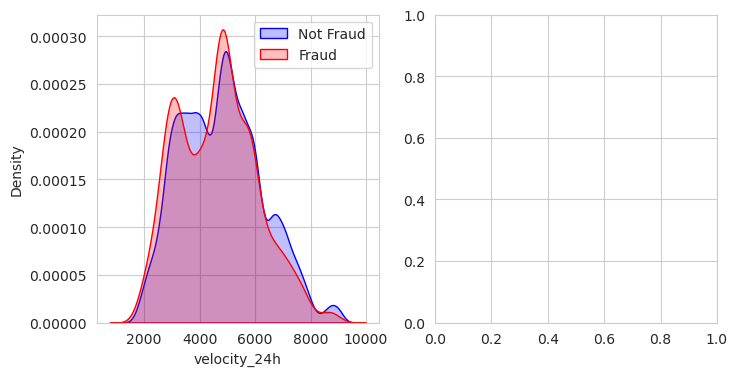

In [19]:
for feature in num_features: 
    if feature != 'fraud_bool' and feature != 'sample_id': # don't plot the target variable nor the ids distribution
        num_summary(df, feature, True)


### Observations:

From the plots, it called my attention:
- Employment status: most, if not all, fraudulent accounts have 'CA' as their employment status
- Source: most, if not all, fraudulent applications are exclusively opened via the internet
- Foreign_request: most, if not all, fraudulent applicants have '0'. 
- Income: the majority of fraudulent accounts report an income greater than 0.6
- Name-email similarity: fraudulent accounts tend to have less similarity between the account holder's name and email address
- Age: the distribution of the age seems to start at 10 but is because the age feature is binned in the dataset, so individuals aged 10-19 are represented as 10.
- Home phone validity: both fraudulent and non-fraudulent applicants tend to have more invalid home phone numbers.
- Mobile phone validity: both fraud and non-fraud generally have valid mobile phone numbers.
- Given that the device_fraud_count plot didn't work and I got the warning that 'Dataset has 0 variance', I will check the values inside of it.  

Also, there seem to be many extreme values in the numerical features, however, given that there's no clear outliers exclusively to no-fraudulent accounts (setting for example all samples with 'session_length_in_minutes'>40 or even 60 as outliers would also remove many fraudulent accounts) I won't look any further into them as I don't want to delete fraudulent samples. 

In [20]:
df.groupBy("device_fraud_count").count().orderBy("device_fraud_count").show()

+------------------+------+
|device_fraud_count| count|
+------------------+------+
|                 0|899809|
+------------------+------+



Given that all values in 'device_fraud_count' are 0, I will drop the feature. 

In [21]:
df = df.drop("device_fraud_count")
test_df = test_df.drop("device_fraud_count")
num_features.remove('device_fraud_count')
num_features.remove('sample_id')

# 5. Which features to build the model? 
I would have liked to use RFE to select the most relevant features, but pyspark doesn't have it inbuilt. I could do it myself (training a model, then computing feature importance, removing the least important feautre, and then training again until X number of features is selected and the performance doesn't go below Y) but I don't think the point of this assignment is to squeeze model performance. So I will just look at some simple correlation scores for num features and at chi-square test for cat features, and i will try to get rid of some features. I am doing this for completness, but also given that the model that we will build is GBT, it will be quiet robust anyways to less relevant features. 

## 5.1. Numerical features

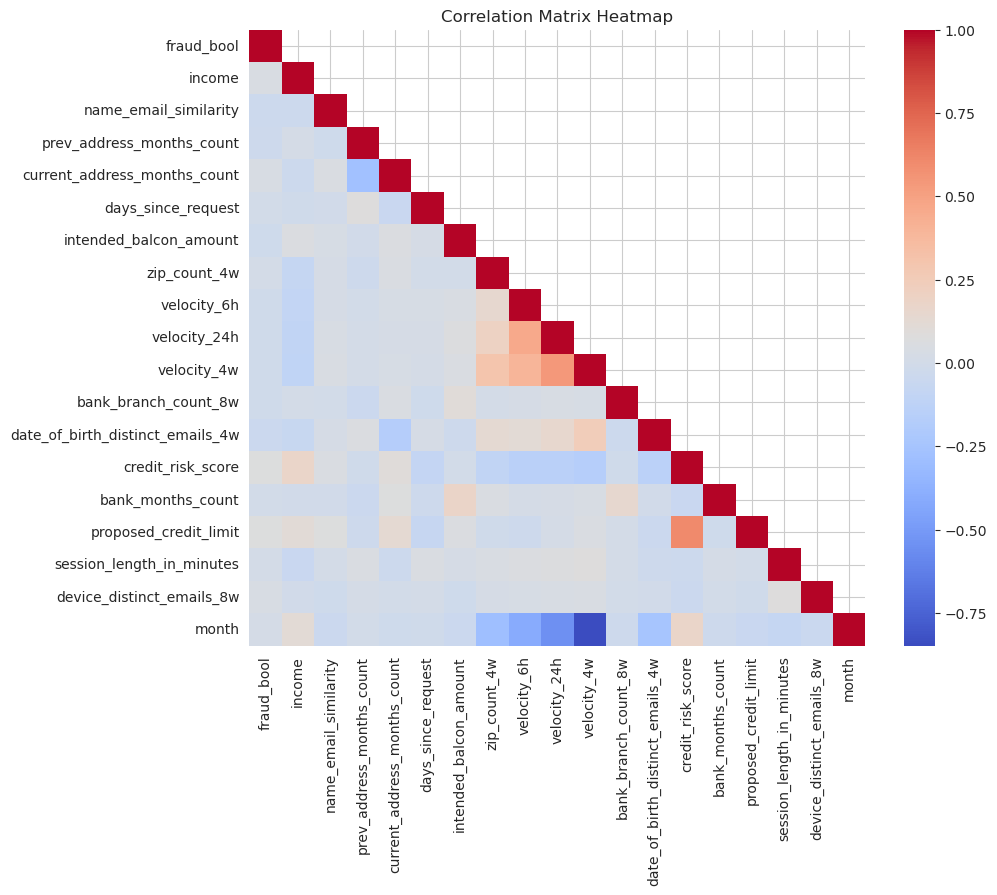

In [22]:
# get the features into a single vector column
assembler = VectorAssembler(inputCols=num_features, outputCol='features')
df_vector = assembler.transform(df).select('features')

# compute correlation matrix
correlation_matrix = Correlation.corr(df_vector, 'features').head()[0]

# cnvert the correlation matrix to a np array to then make it a pd dataframe 
corr_matrix_np = correlation_matrix.toArray()
corr_df = pd.DataFrame(corr_matrix_np, index=num_features, columns=num_features)

# mask to show only the lower triangle of matrix
mask = np.triu(np.ones_like(corr_df, dtype=bool), k=1) #k=1 keeps the diagonal - which is fraud_bool


# plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, mask = mask, cmap="coolwarm", annot=False, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

### Observation: all numerical features seem to be highly corralated to the target, so we don't need to remove any. 

## 5.2. Categorical features

For the categorical features, I will apply chi square test. I saw before (from the plots with distributions) that certain categories from 'employment_status', 'source' and 'foreign_request' have a clear correlation with fraudulent applicants, so I will only check the rest. Now, because chiSqSelector from pyspark requires features to have num values, I will one hot encode them:

In [23]:
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in cat_features]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in cat_features]
encoded_cols = [col + "_encoded" for col in cat_features]  # list of encoded columns

pipeline = Pipeline(stages=indexers + encoders)
df_encoded = pipeline.fit(df).transform(df)

df_encoded will have now 3 columns now for each categorical feature. Exampple: if the feature was called: 'cat_feature', now there are: 'cat_feature', 'cat_feature_index', 'cat_feature_encoded'. The first is the same as before, the ..index contains an integer representing the category, and the ..encoded contains the one hot encoded vector.  See the example below:



In [24]:
df_encoded.select("payment_type", "payment_type_index", "payment_type_encoded").show(truncate=False)

# (4,[1],[1.0]): 4 represents that there are 4 categories, [1] is the index within the vector where 1.0 occurs. 

+------------+------------------+--------------------+
|payment_type|payment_type_index|payment_type_encoded|
+------------+------------------+--------------------+
|AB          |0.0               |(4,[0],[1.0])       |
|AB          |0.0               |(4,[0],[1.0])       |
|AB          |0.0               |(4,[0],[1.0])       |
|AC          |2.0               |(4,[2],[1.0])       |
|AB          |0.0               |(4,[0],[1.0])       |
|AC          |2.0               |(4,[2],[1.0])       |
|AB          |0.0               |(4,[0],[1.0])       |
|AA          |1.0               |(4,[1],[1.0])       |
|AB          |0.0               |(4,[0],[1.0])       |
|AC          |2.0               |(4,[2],[1.0])       |
|AB          |0.0               |(4,[0],[1.0])       |
|AA          |1.0               |(4,[1],[1.0])       |
|AD          |3.0               |(4,[3],[1.0])       |
|AB          |0.0               |(4,[0],[1.0])       |
|AB          |0.0               |(4,[0],[1.0])       |
|AB       

In [25]:
assembler = VectorAssembler(inputCols=encoded_cols, outputCol="features")
df_encoded_vector = assembler.transform(df_encoded)

# apply the Chi-Squared test 
chi_sq_result = ChiSquareTest.test(df_encoded_vector, "features", "fraud_bool")

result = chi_sq_result.collect()[0]
p_values = result["pValues"]
statistics = result["statistics"]

# get mapping back from one hot encoded features to their names (not the same, but with an 'index' per each category within feature
# like: categorical_feature_index)
expanded_feature_names = []
for col in encoded_cols:
    num_categories = df_encoded.select(col).head()[0].size # check how many categories each feature has 
    expanded_feature_names.extend([f"{col}_{i}" for i in range(num_categories)]) # create names by adding an index based on how many categories the feature has 

chi_sq_df = pd.DataFrame({
    'Feature': expanded_feature_names,
    'Chi-Squared Statistic': statistics,
    'p-value': p_values,
})

chi_sq_df

,Feature,Chi-Squared Statistic,p-value
0,payment_type_encoded_0,3.098495,7.836469e-02
1,payment_type_encoded_1,959.998287,0.000000e+00
2,payment_type_encoded_2,894.109568,0.000000e+00
3,payment_type_encoded_3,0.664596,4.149420e-01
4,employment_status_encoded_0,299.932616,0.000000e+00
5,employment_status_encoded_1,239.979944,0.000000e+00
6,employment_status_encoded_2,309.399346,0.000000e+00
7,employment_status_encoded_3,631.437726,0.000000e+00
8,employment_status_encoded_4,118.911287,0.000000e+00
9,employment_status_encoded_5,144.244351,0.000000e+00


- A higher chi-squared statistic indicates stronger association between the category and the targe
- p value is used to check if relationship is statistically significant. 

I will sort the df and add a new column to check if result is statitically sifnicant or not (using 0.05 as treshold):

In [26]:
chi_sq_df['significant'] = chi_sq_df['p-value'] < 0.05
chi_sq_df_sorted = chi_sq_df.sort_values(by='Chi-Squared Statistic', ascending=False)

chi_sq_df_sorted

,Feature,Chi-Squared Statistic,p-value,significant
12,housing_status_encoded_2,11917.805892,0.000000e+00,True
19,device_os_encoded_2,5533.120504,0.000000e+00,True
21,keep_alive_session_encoded_0,2225.656426,0.000000e+00,True
31,customer_age_encoded_4,1497.913990,0.000000e+00,True
18,device_os_encoded_1,1423.513159,0.000000e+00,True
17,device_os_encoded_0,1194.945037,0.000000e+00,True
10,housing_status_encoded_0,1154.879006,0.000000e+00,True
23,has_other_cards_encoded_0,1106.700806,0.000000e+00,True
25,phone_home_valid_encoded_0,1106.463730,0.000000e+00,True
30,customer_age_encoded_3,1079.296899,0.000000e+00,True


### Observations: I don't think any feature can be deleted or not used during trainig because even the ones with lower chi-squared values (like 'payment_type_encoded_3') have another of their categories higher ranked.